In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Credit Risk Analyst: Calculate Loan Borrowers Probability of Default (PD)
### Task 3:
The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default).

Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss. You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis. Submit your code below.

Logistic Regression AUC-ROC: 1.0000
Decision Tree AUC-ROC: 0.9897
Random Forest AUC-ROC: 0.9999


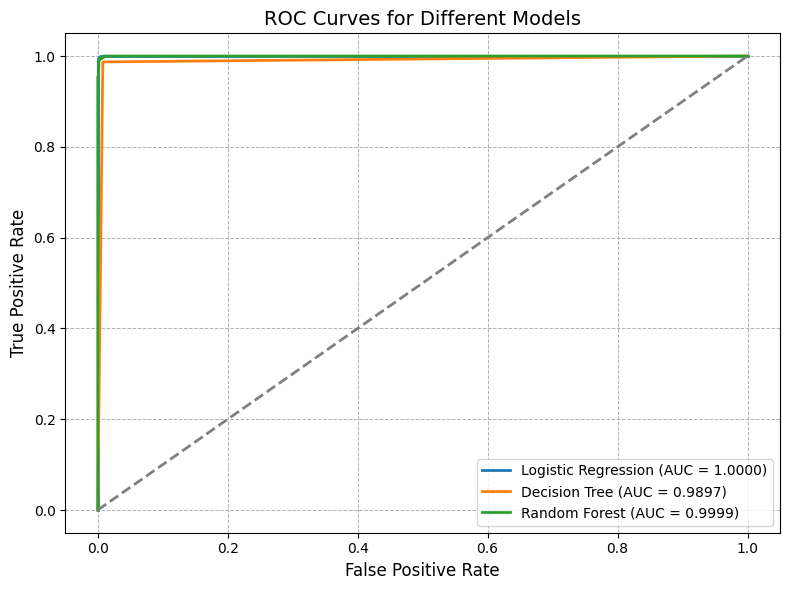

In [2]:
# Load the dataset
dataframe = pd.read_csv('Task3n4_Loan_Data.csv')

# Create new features: Payment to Income Ratio and Debt to Income Ratio
dataframe['payment_to_income'] = dataframe['loan_amt_outstanding'] / dataframe['income']
dataframe['debt_to_income'] = dataframe['total_debt_outstanding'] / dataframe['income']

# Features for model training
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']
target = 'default'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(dataframe[features], dataframe[target], test_size=0.3, random_state=42)

# Standardize the features (important for many machine learning algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to be compared
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train each model and evaluate performance
model_results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities (for PD estimation)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate AUC-ROC score
    auc = roc_auc_score(y_test, y_pred_proba)
    model_results[name] = auc

    # Print performance
    print(f"{name} AUC-ROC: {auc:.4f}")


# Improved ROC Curve Plot
plt.figure(figsize=(8, 6))  # Adjusted figure size for better visualization

# Iterate over the models and plot their ROC curves
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Smoothing curve by using an interpolation or spline (if required)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {model_results[name]:.4f})', linewidth=2)

# Plot the random chance line (diagonal)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=2)

# Set plot limits, labels, and title for better visualization
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Different Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

In [3]:
# Final Function: Expected Loss Calculation based on PD
def calculate_expected_loss(loan_data, model, scaler, recovery_rate=0.10):
    """
    Calculate the expected loss given a loan's properties.
    
    :param loan_data: Dictionary containing loan parameters (income, outstanding loan, debt, etc.)
    :param model: Trained model to predict PD
    :param scaler: Scaler to standardize input data
    :param recovery_rate: Recovery rate, default is 10%
    :return: Expected loss on the loan
    """
    # Prepare input data
    loan_df = pd.DataFrame([loan_data])
    
    # Feature engineering
    loan_df['payment_to_income'] = loan_df['loan_amt_outstanding'] / loan_df['income']
    loan_df['debt_to_income'] = loan_df['total_debt_outstanding'] / loan_df['income']
    
    # Select the same features as used in training
    loan_features = loan_df[features]
    
    # Standardize the features
    loan_features_scaled = scaler.transform(loan_features)
    
    # Predict the probability of default (PD)
    pd_pred = model.predict_proba(loan_features_scaled)[:, 1][0]
    
    # Calculate the expected loss
    loan_amount = loan_df['loan_amt_outstanding'].values[0]
    expected_loss = pd_pred * (1 - recovery_rate) * loan_amount
    
    return expected_loss, pd_pred

In [4]:
# Example loan data for testing the function
test_loan = {
    'credit_lines_outstanding': 3,
    'debt_to_income': 0.2,
    'payment_to_income': 0.5,
    'years_employed': 10,
    'fico_score': 780,
    'income': 50000,
    'loan_amt_outstanding': 15000,
    'total_debt_outstanding': 20000
}

# Use the best model (Random Forest in this case, but adjust based on performance)
best_model = models['Random Forest']
expected_loss, predicted_pd = calculate_expected_loss(test_loan, best_model, scaler)

print(f"Predicted PD: {predicted_pd:.4f}")
print(f"Expected Loss: ${expected_loss:.2f}")

Predicted PD: 0.4400
Expected Loss: $5940.00
